# 导入必须的库

In [34]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import h5py
from matplotlib import pyplot as plt
from IPython import display
from matplotlib_inline import backend_inline
from torchvision.transforms import functional as F
import cv2

from PIL import Image


import torch.nn.functional as F1 
## 定义动态曲线类
from animator import Animator, use_svg_display, set_axes

# 定义必须函数

## 图像质量评估

In [35]:
import torch
import pyiqa
from pyiqa import imread2tensor

In [36]:
lpips_metric = pyiqa.create_metric('lpips').cuda()
niqe_metric = pyiqa.create_metric('niqe').cuda()
fid_metric = pyiqa.create_metric('fid')

Loading pretrained model LPIPS from C:\Users\user\.cache\torch\hub\checkpoints\LPIPS_v0.1_alex-df73285e.pth
Loading pretrained model Inception3 from C:\Users\user\.cache\torch\hub\checkpoints\pt_inception-2015-12-05-6726825d.pth


## 图像通道转换

In [37]:
def imgConvert(img):
    img = img.convert('RGB')
    return img

## 涡度计算

In [38]:
def vorticity1(U_x, U_y, dx, dy):
    dU_y_dx, _ = np.gradient(U_y, dx, axis=0), np.gradient(U_y, dy, axis=1)
    _, dU_x_dy = np.gradient(U_x, dx, axis=0), np.gradient(U_x, dy, axis=1)
    return dU_y_dx - dU_x_dy

def vorticity_normalize1(vorticity):
    max_vorticity = np.max(np.abs(vorticity))
    vort_normalized = vorticity / max_vorticity if max_vorticity != 0 else vorticity
    return vort_normalized

# 查询CUDA和文件路径

In [39]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# 文件路径
file_path = r'D:\\zjPhD\\turbulenceData\\turbulenceData\\isotropic1024coarse_10.h5'


Using device: cuda


# 基本定义

## 定义尺寸

In [40]:
size_low = 64

dx = 2*np.pi/size_low
dy = 2*np.pi/size_low
dz = 2*np.pi/size_low


## 读取文件

In [41]:
# 读取HDF5文件
with h5py.File(file_path, 'r') as f:
    datasets = list(f.keys())
    print("数据集列表:", datasets)
    dataset_name = datasets[0]
    data = f[dataset_name][()]
    print(f"{dataset_name} 数据形状:", data.shape)
    print(f"{dataset_name} 数据范围:", data.min(), "到", data.max())

file_path_test = r'D:\\zjPhD\\turbulenceData\\turbulenceData\\isotropic1024coarse_test.h5'


数据集列表: ['Velocity_0001', 'Velocity_0002', 'Velocity_0003', 'Velocity_0004', 'Velocity_0005', 'Velocity_0006', 'Velocity_0007', 'Velocity_0008', 'Velocity_0009', 'Velocity_0010', 'Velocity_0011', 'Velocity_0012', 'Velocity_0013', 'Velocity_0014', 'Velocity_0015', 'Velocity_0016', 'Velocity_0017', 'Velocity_0018', 'Velocity_0019', 'Velocity_0020', 'xcoor', 'ycoor', 'zcoor']
Velocity_0001 数据形状: (1, 1024, 1024, 3)
Velocity_0001 数据范围: -2.712391 到 2.6947422


In [42]:
with h5py.File(file_path_test, 'r') as f:
    datasets = list(f.keys())
    print("数据集列表:", datasets)
    dataset_name = datasets[0]
    data = f[dataset_name][()]
    print(f"{dataset_name} 数据形状:", data.shape)
    print(f"{dataset_name} 数据范围:", data.min(), "到", data.max())
    data_normalized = (data[0] - data.min()) / (data.max() - data.min())
    u_test = data_normalized[:,:,0]
    v_test = data_normalized[:,:,1]
    w_test = data_normalized[:,:,2]


数据集列表: ['Velocity_0001', 'xcoor', 'ycoor', 'zcoor']
Velocity_0001 数据形状: (1, 1024, 1024, 3)
Velocity_0001 数据范围: -2.712391 到 2.6947422


## 定义下采样

原始文件中尺寸为1024*1024，我们通过resize下采样到64*64

In [43]:
def downsample(image, size=(64, 64)):
    return cv2.resize(image, size, interpolation=cv2.INTER_CUBIC)


## 读取文件并定义数据集

In [44]:
with h5py.File(file_path, 'r') as f:
    velocity_datasets = [name for name in f.keys() if 'Velocity' in name]
    all_velocity_fields = []

    for dataset_name in velocity_datasets:
        data = f[dataset_name][()]
        U_x = data[0, :, :, 0]
        U_y = data[0, :, :, 1]
        U_magnitude = data[0, :, :, 2]

        U_x_downsampled = downsample(U_x)
        U_y_downsampled = downsample(U_y)
        U_magnitude_downsampled = downsample(U_magnitude)

        U_x_tensor = torch.tensor(U_x_downsampled, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)
        U_y_tensor = torch.tensor(U_y_downsampled, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)
        U_magnitude_tensor = torch.tensor(U_magnitude_downsampled, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)

        velocity_field = torch.cat((U_x_tensor, U_y_tensor, U_magnitude_tensor), dim=1)
        all_velocity_fields.append(velocity_field)

    all_velocity_fields = torch.cat(all_velocity_fields, dim=0)
    num_samples = all_velocity_fields.shape[0]
    size_low = all_velocity_fields.shape[2]
    target_abcd = torch.zeros((num_samples, 4, size_low, size_low), dtype=torch.float32).to(device)

    dataset = TensorDataset(all_velocity_fields, target_abcd)
    dataloader = DataLoader(dataset, batch_size=2, shuffle=True)

print("all_velocity_fields shape:", all_velocity_fields.shape)
print("target_abcd shape:", target_abcd.shape)


all_velocity_fields shape: torch.Size([20, 3, 64, 64])
target_abcd shape: torch.Size([20, 4, 64, 64])


In [45]:
U_x = data[0, :, :, 0]
U_y = data[0, :, :, 1]
U_magnitude = data[0, :, :, 2]

U_x.shape, U_y.shape, U_magnitude.shape

((1024, 1024), (1024, 1024), (1024, 1024))

In [46]:
size_high = U_x.shape[0]

dx = 2*np.pi/size_high
dy = 2*np.pi/size_high


In [47]:
vort_test = vorticity1(U_x, U_y, 64, 64)

vorticity_normalized = vorticity_normalize1(vort_test)


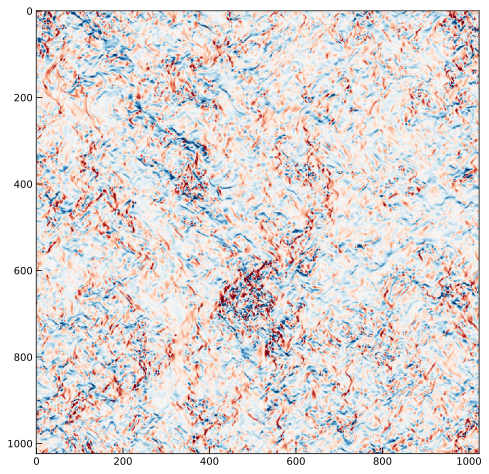

In [48]:
plt.figure(figsize=(8, 8))

plt.imshow(vorticity_normalized,cmap='RdBu_r', vmin=-0.2, vmax=0.2, interpolation='nearest')
# plt.colorbar()
plt.tick_params(axis='both', direction='in', length=6)
# plt.axis('off')


## 计算下采样后的涡度

In [49]:
vort_test = vorticity1(U_x_downsampled, U_y_downsampled, dx, dx)

vorticity_normalized = vorticity_normalize1(vort_test)


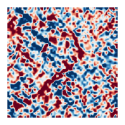

In [50]:
plt.figure(figsize=(2, 2))

plt.imshow(vorticity_normalized,cmap='RdBu_r', vmin=-0.2, vmax=0.2, interpolation='bilinear')
# plt.colorbar()
plt.tick_params(axis='both', direction='in', length=6)
plt.axis('off')

plt.savefig("D:\\zjPhD\Programzj\\psiToU\\result\\8_1\\high\\omega_real_64.png",dpi=128,bbox_inches='tight',pad_inches = 0)

img = Image.open("D:\\zjPhD\Programzj\\psiToU\\result\\8_1\\high\\omega_real_64.png")
img = imgConvert(img)
img.save("D:\\zjPhD\Programzj\\psiToU\\result\\8_1\\high\\omega_real_64.png")


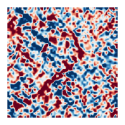

In [61]:
plt.figure(figsize=(2, 2))

plt.imshow(vorticity_normalized,cmap='RdBu_r', vmin=-0.2, vmax=0.2, interpolation='bilinear')
# plt.colorbar()
plt.tick_params(axis='both', direction='in', length=6)
plt.axis('off')

plt.savefig("D:\\zjPhD\Programzj\\psiToU\\result\\8_1\\high\\omega_real_1024.png",dpi=2047,bbox_inches='tight',pad_inches = 0)

img = Image.open("D:\\zjPhD\Programzj\\psiToU\\result\\8_1\\high\\omega_real_1024.png")
img = imgConvert(img)
img.save("D:\\zjPhD\Programzj\\psiToU\\result\\8_1\\high\\omega_real_1024.png")


# 提取model建立

## 定义简单模型

In [51]:
class BasicModelA(nn.Module):
    def __init__(self):
        super(BasicModelA, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(512)
        self.upsample = nn.Upsample(scale_factor=8, mode='bilinear', align_corners=True)
        self.conv5 = nn.Conv2d(512, 4, kernel_size=3, padding=1)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool(x)
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool(x)
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.upsample(x)
        x = self.conv5(x)
        return x


## 定义复杂模型

In [52]:
class ComplexModelA(nn.Module):
    def __init__(self):
        super(ComplexModelA, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(512)
        self.conv5 = nn.Conv2d(512, 1024, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(1024)
        self.pool = nn.MaxPool2d(2, 2)
        self.upconv1 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.conv6 = nn.Conv2d(1024, 512, kernel_size=3, padding=1)
        self.bn6 = nn.BatchNorm2d(512)
        self.upconv2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.conv7 = nn.Conv2d(512, 256, kernel_size=3, padding=1)
        self.bn7 = nn.BatchNorm2d(256)
        self.upconv3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.conv8 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
        self.bn8 = nn.BatchNorm2d(128)
        self.upconv4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.conv9 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.bn9 = nn.BatchNorm2d(64)
        self.conv10 = nn.Conv2d(64, 4, kernel_size=3, padding=1)

    def forward(self, x):
        x1 = F1.relu(self.bn1(self.conv1(x)))
        x2 = self.pool(x1)
        x2 = F1.relu(self.bn2(self.conv2(x2)))
        x3 = self.pool(x2)
        x3 = F1.relu(self.bn3(self.conv3(x3)))
        x4 = self.pool(x3)
        x4 = F1.relu(self.bn4(self.conv4(x4)))
        x5 = self.pool(x4)
        x5 = F1.relu(self.bn5(self.conv5(x5)))
        x = self.upconv1(x5)
        x = torch.cat((x, x4), dim=1)
        x = F1.relu(self.bn6(self.conv6(x)))
        x = self.upconv2(x)
        x = torch.cat((x, x3), dim=1)
        x = F1.relu(self.bn7(self.conv7(x)))
        x = self.upconv3(x)
        x = torch.cat((x, x2), dim=1)
        x = F1.relu(self.bn8(self.conv8(x)))
        x = self.upconv4(x)
        x = torch.cat((x, x1), dim=1)
        x = F1.relu(self.bn9(self.conv9(x)))
        x = self.conv10(x)
        return x


In [53]:
class ConstraintLayer(nn.Module):
    def __init__(self):
        super(ConstraintLayer, self).__init__()

    def forward(self, x):
        norm = torch.sqrt(x[:, 0, :, :]**2 + x[:, 1, :, :]**2 + x[:, 2, :, :]**2 + x[:, 3, :, :]**2 + 1e-8)
        norm = norm.unsqueeze(1)
        x = x / norm
        return x


In [54]:
class ModelAWithConstraints(nn.Module):
    def __init__(self):
        super(ModelAWithConstraints, self).__init__()
        self.model = BasicModelA()
        self.constraint_layer = ConstraintLayer()

    def forward(self, x):
        x = self.model(x)
        x = self.constraint_layer(x)
        return x


In [55]:
def calculate_gradients_with_numpy(tensor):
    tensor_np = tensor.detach().cpu().numpy()
    grad_x = np.gradient(tensor_np, axis=1)
    grad_y = np.gradient(tensor_np, axis=2)
    grad_x_tensor = torch.from_numpy(grad_x).to(tensor.device)
    grad_y_tensor = torch.from_numpy(grad_y).to(tensor.device)
    return grad_x_tensor, grad_y_tensor


In [56]:
def laplacian_2d_torch(tensor, dx, dy):
    tensor = tensor.float()
    tensor_np = tensor.detach().cpu().numpy()
    grad_x = np.gradient(tensor_np, axis=1)
    grad_y = np.gradient(tensor_np, axis=2)
    laplacian_x = np.gradient(grad_x, axis=1)
    laplacian_y = np.gradient(grad_y, axis=2)
    laplacian_x_tensor = torch.from_numpy(laplacian_x).to(tensor.device)
    laplacian_y_tensor = torch.from_numpy(laplacian_y).to(tensor.device)
    laplacian = laplacian_x_tensor + laplacian_y_tensor
    return laplacian


## 定义损失函数

In [57]:

def loss_function(predicted_abcd, true_velocity, model, epsilon, dx, dy, l1_lambda=0.0, l2_lambda=0.0):
    a = predicted_abcd[:, 0, :, :]
    b = predicted_abcd[:, 1, :, :]
    c = predicted_abcd[:, 2, :, :]
    d = predicted_abcd[:, 3, :, :]
    
    a_grad_x, a_grad_y = calculate_gradients_with_numpy(a)
    b_grad_x, b_grad_y = calculate_gradients_with_numpy(b)
    c_grad_x, c_grad_y = calculate_gradients_with_numpy(c)
    d_grad_x, d_grad_y = calculate_gradients_with_numpy(d)

    U_x_pred = a + b
    U_y_pred = c + d
    U_magnitude_pred = torch.sqrt(U_x_pred**2 + U_y_pred**2)

    U_x_pred_numpy = U_x_pred.detach().cpu().numpy()
    U_y_pred_numpy = U_y_pred.detach().cpu().numpy()
    U_magnitude_pred_numpy = U_magnitude_pred.detach().cpu().numpy()

    vort_pred = vorticity1(U_x_pred_numpy, U_y_pred_numpy, dx, dx)
    vorticity_normalized_pred = vorticity_normalize1(vort_pred)

    U_x_true = true_velocity[:, 0, :, :]
    U_y_true = true_velocity[:, 1, :, :]
    U_magnitude_true = torch.sqrt(U_x_true**2 + U_y_true**2)

    U_x_true_numpy = U_x_true.detach().cpu().numpy()
    U_y_true_numpy = U_y_true.detach().cpu().numpy()

    vort_true = vorticity1(U_x_true_numpy, U_y_true_numpy, dx, dx)
    vorticity_normalized_true = vorticity_normalize1(vort_true)

    loss_omega = F1.mse_loss(torch.tensor(vorticity_normalized_pred).to(device), torch.tensor(vorticity_normalized_true).to(device))
    
    loss_velocity = F1.mse_loss(U_magnitude_pred, U_magnitude_true) + F1.mse_loss(U_x_pred, U_x_true) + F1.mse_loss(U_y_pred, U_y_true)
    
    l1_regularization = torch.tensor(0., requires_grad=True)
    
    if l1_lambda > 0:
        l1_regularization = sum(torch.sum(torch.abs(param)) for param in model.parameters())
    l2_regularization = torch.tensor(0., requires_grad=True)
    if l2_lambda > 0:
        l2_regularization = sum(torch.sum(param**2) for param in model.parameters())
    regularization_term = epsilon * 0.25 * (torch.sum(a**2) + torch.sum(b**2) + torch.sum(c**2) + torch.sum(d**2))
    
    total_loss = loss_velocity + l1_lambda * l1_regularization + l2_lambda * l2_regularization + loss_omega
    
    return total_loss


## 超参数设置

In [58]:
learning_rate = 0.00001
num_epochs = 1000
epsilon = 0.01
l1_lambda = 0.001
l2_lambda = 0.001
channels = 3


In [59]:
model = ComplexModelA().to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


# 模型训练

KeyboardInterrupt: 

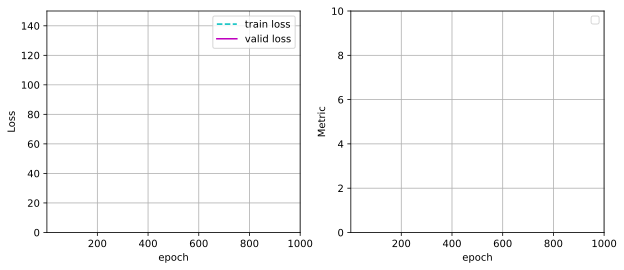

In [60]:
animator = Animator(
    xlabels=["epoch", "epoch"],
    ylabels=["Loss", "Metric"],
    legends=[["train loss", "valid loss"], ["train metric", "valid metric"]],
    xlims=[[1, num_epochs], [1, num_epochs]],
    ylims=[[0, 150], [0, 10]]
)

for epoch in range(num_epochs):
    epoch_loss = 0
    for i, (velocity, _) in enumerate(dataloader):
        velocity = velocity.to(device)
        optimizer.zero_grad()
        predicted_abcd = model(velocity)
        loss = loss_function(predicted_abcd, velocity, model, epsilon, dx, dy, l1_lambda, l2_lambda)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    epoch_loss /= len(dataloader)
    animator.add(epoch + 1, (epoch_loss, 0))
    if i % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}], Loss: {loss.item():.4f}')

## 保存结果

In [ ]:
predicted_abcd = predicted_abcd.cpu()  # 将预测结果移回CPU以便进行后续处理和可视化
a_pre = predicted_abcd[1,0,:,:].detach().numpy()
b_pre = predicted_abcd[1,1,:,:].detach().numpy()
c_pre = predicted_abcd[1,2,:,:].detach().numpy()
d_pre = predicted_abcd[1,3,:,:].detach().numpy()


In [ ]:
a_test_grad_x, a_test_grad_y = np.gradient(a_pre, dx)
b_test_grad_x, b_test_grad_y = np.gradient(b_pre, dx)
c_test_grad_x, c_test_grad_y = np.gradient(c_pre, dx)
d_test_grad_x, d_test_grad_y = np.gradient(d_pre, dx)
U_x_pred_test = a_pre + b_pre
U_y_pred_test = c_pre + d_pre
U_magnitude_pred_test = np.sqrt(U_x_pred_test**2 + U_y_pred_test**2)



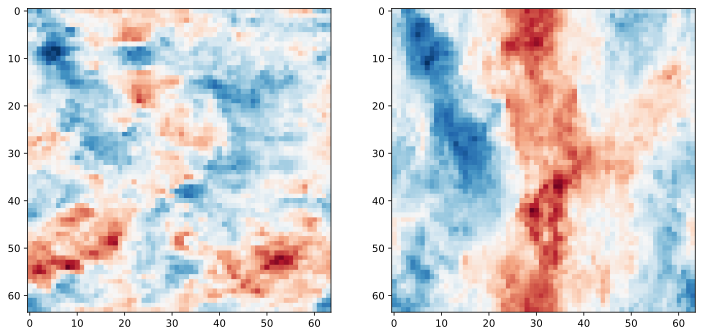

In [ ]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(U_x_pred_test, cmap='RdBu_r',)
plt.subplot(1, 2, 2)
plt.imshow(U_y_pred_test, cmap='RdBu_r')



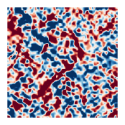

In [ ]:
# 预测结果
vort_pre = vorticity1(U_x_pred_test, U_y_pred_test, dx, dx)
vorticity_normalized_pre = vorticity_normalize1(vort_pre)

plt.figure(figsize=(2, 2))

plt.imshow(vorticity_normalized_pre, cmap='RdBu_r', vmin=-0.2, vmax=0.2, interpolation='bilinear')
# plt.colorbar()
plt.tick_params(axis='both', direction='in', length=6)
plt.axis('off')

plt.savefig("D:\\zjPhD\Programzj\\psiToU\\result\\8_1\\low\\omega_pre_64.png",dpi=128,bbox_inches='tight',pad_inches = 0)

img = Image.open("D:\\zjPhD\Programzj\\psiToU\\result\\8_1\\low\\omega_pre_64.png")
img = imgConvert(img)
img.save("D:\\zjPhD\Programzj\\psiToU\\result\\8_1\\low\\omega_pre_64.png")



# 评估图片重建前后

In [ ]:
# 图片路径
real_img_path = r'D:\zjPhD\Programzj\psiToU\result\8_1\high\omega_real_64.png'
pred_img_path = r'D:\zjPhD\Programzj\psiToU\result\8_1\low\omega_pre_64.png'

# 读取图片并转换为张量
real_img_tensor = imread2tensor(real_img_path).unsqueeze(0).to(device)
pred_img_tensor = imread2tensor(pred_img_path).unsqueeze(0).to(device)

# 定义图片所在目录
real_img_dir = r'D:\zjPhD\Programzj\psiToU\result\8_1\high'
pred_img_dir = r'D:\zjPhD\Programzj\psiToU\result\8_1\low'


### 定义计算指标的函数，输入为路径

In [78]:
def calculate_metrics(real_img_dir, pred_img_dir, real_img_tensor, pred_img_tensor):
    lpips_score = lpips_metric(real_img_tensor, pred_img_tensor)
    niqe_score = niqe_metric(real_img_tensor)
    fid_score = fid_metric(real_img_dir, pred_img_dir)

    print(f'LPIPS: {lpips_score.item():.4f}')
    print(f'NIQE: {niqe_score.item():.4f}')
    print(f'FID: {fid_score.item():.4f}')

In [ ]:
calculate_metrics(real_img_dir, pred_img_dir, real_img_tensor, pred_img_tensor)

compute FID between two folders
Found 1 images in the folder D:\zjPhD\Programzj\psiToU\result\8_1\high


FID high: 100%|██████████| 1/1 [00:08<00:00,  8.28s/it]


Found 1 images in the folder D:\zjPhD\Programzj\psiToU\result\8_1\low


FID low: 100%|██████████| 1/1 [00:08<00:00,  8.59s/it]

LPIPS: 0.0391
NIQE: 19.7842
FID: 20.2671


PSNR: 20.382701 dB 
SSIM: 0.889184
LPIPS: 0.0391
NIQE: 19.7842
FID: 20.2671


### 指标评估

## 直接超分辨得到结果和高分辨对比

In [76]:
# 图片路径
real_img_path = r'D:\zjPhD\Programzj\psiToU\result\8_1\high\1024\omega_real_1024.png'
pred_img_path = r'D:\zjPhD\Programzj\psiToU\result\8_1\high\real1024\omega_real_64_SwinIR_SwinIR.png'

# 读取图片并转换为张量
real_img_tensor = imread2tensor(real_img_path).unsqueeze(0).to(device)
pred_img_tensor = imread2tensor(pred_img_path).unsqueeze(0).to(device)

# 定义图片所在目录
real_img_dir = r'D:\zjPhD\Programzj\psiToU\result\8_1\high\1024'
pred_img_dir = r'D:\zjPhD\Programzj\psiToU\result\8_1\high\real1024'


In [79]:
calculate_metrics(real_img_dir, pred_img_dir, real_img_tensor, pred_img_tensor)

compute FID between two folders
Found 1 images in the folder D:\zjPhD\Programzj\psiToU\result\8_1\high\1024


FID 1024: 100%|██████████| 1/1 [00:09<00:00,  9.18s/it]


Found 1 images in the folder D:\zjPhD\Programzj\psiToU\result\8_1\high\real1024


FID real1024: 100%|██████████| 1/1 [00:09<00:00,  9.09s/it]

LPIPS: 0.2790
NIQE: 20.0708
FID: 40.5935


## 使用我们的方法

In [80]:
# 图片路径
real_img_path = r'D:\zjPhD\Programzj\psiToU\result\8_1\high\1024\omega_real_1024.png'
pred_img_path = r'D:\zjPhD\Programzj\psiToU\result\8_1\low\1024\omega_pre_64_SwinIR_SwinIR.png'

# 读取图片并转换为张量
real_img_tensor = imread2tensor(real_img_path).unsqueeze(0).to(device)
pred_img_tensor = imread2tensor(pred_img_path).unsqueeze(0).to(device)

# 定义图片所在目录
real_img_dir = r'D:\zjPhD\Programzj\psiToU\result\8_1\high\1024'
pred_img_dir = r'D:\zjPhD\Programzj\psiToU\result\8_1\low\1024'

In [81]:
calculate_metrics(real_img_dir, pred_img_dir, real_img_tensor, pred_img_tensor)

compute FID between two folders
Found 1 images in the folder D:\zjPhD\Programzj\psiToU\result\8_1\high\1024


FID 1024: 100%|██████████| 1/1 [00:08<00:00,  8.67s/it]


Found 1 images in the folder D:\zjPhD\Programzj\psiToU\result\8_1\low\1024


FID 1024: 100%|██████████| 1/1 [00:08<00:00,  8.73s/it]

LPIPS: 0.4181
NIQE: 20.0708
FID: 45.0585


结果存储在：
D:\zjPhD\Programzj\psiToU\result\8_1\1024对比\
对比结果如上面所示

| 方案         | LPIPS          | NIQE         |   FID|
| -----------  | -----------   | ----------- |----------- |
| 直接16倍超分  | 0.2790         |20.0708       |40.5935       |
| ourways      | 0.4181        |20.0708       |45.0585       |
